In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20, 6)
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [187]:
df = pd.read_csv('./data/Electric_Production.csv')
df.head()

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


In [188]:
df.shape

(397, 2)

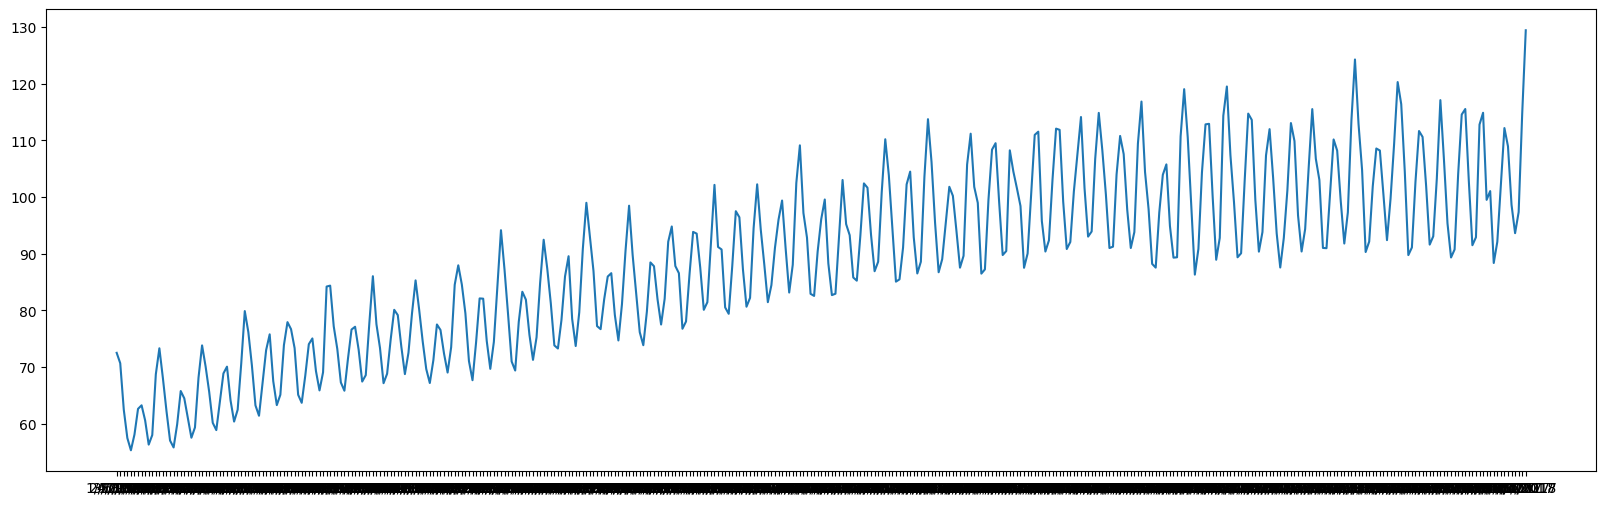

In [189]:
plt.plot(df['DATE'], df['IPG2211A2N'])

In [190]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        397 non-null    object 
 1   IPG2211A2N  397 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.3+ KB


In [191]:
df.columns

Index(['DATE', 'IPG2211A2N'], dtype='object')

In [192]:
df.rename(columns={'IPG2211A2N':'values'}, inplace=True)

In [193]:
df['DATE'] = pd.to_datetime(df['DATE'])

In [194]:
df.head()

,DATE,values
0,1985-01-01,72.5052
1,1985-02-01,70.6720
2,1985-03-01,62.4502
3,1985-04-01,57.4714
4,1985-05-01,55.3151


In [195]:
df.describe()

,values
count,397.000000
mean,88.847218
std,15.387834
min,55.315100
25%,77.105200
50%,89.779500
75%,100.524400
max,129.404800


In [196]:
df.set_index('DATE',inplace=True)

In [197]:
df.columns

Index(['values'], dtype='object')

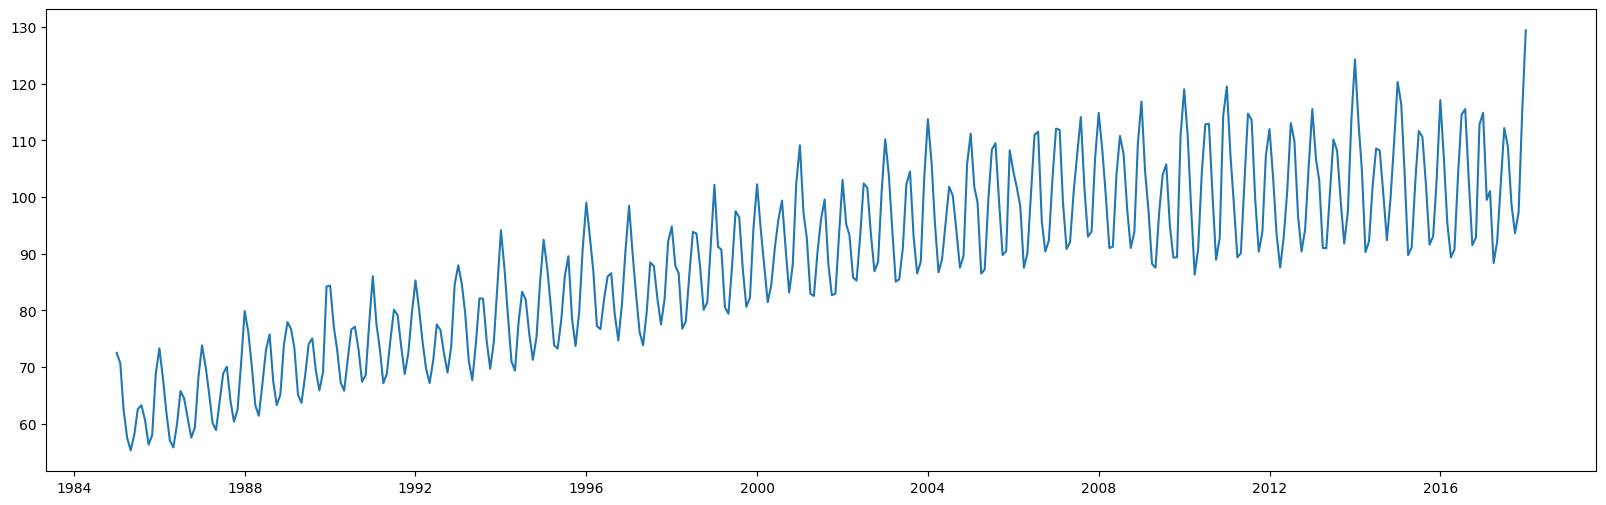

In [198]:
plt.plot(df.index, df.values)

<Axes: >

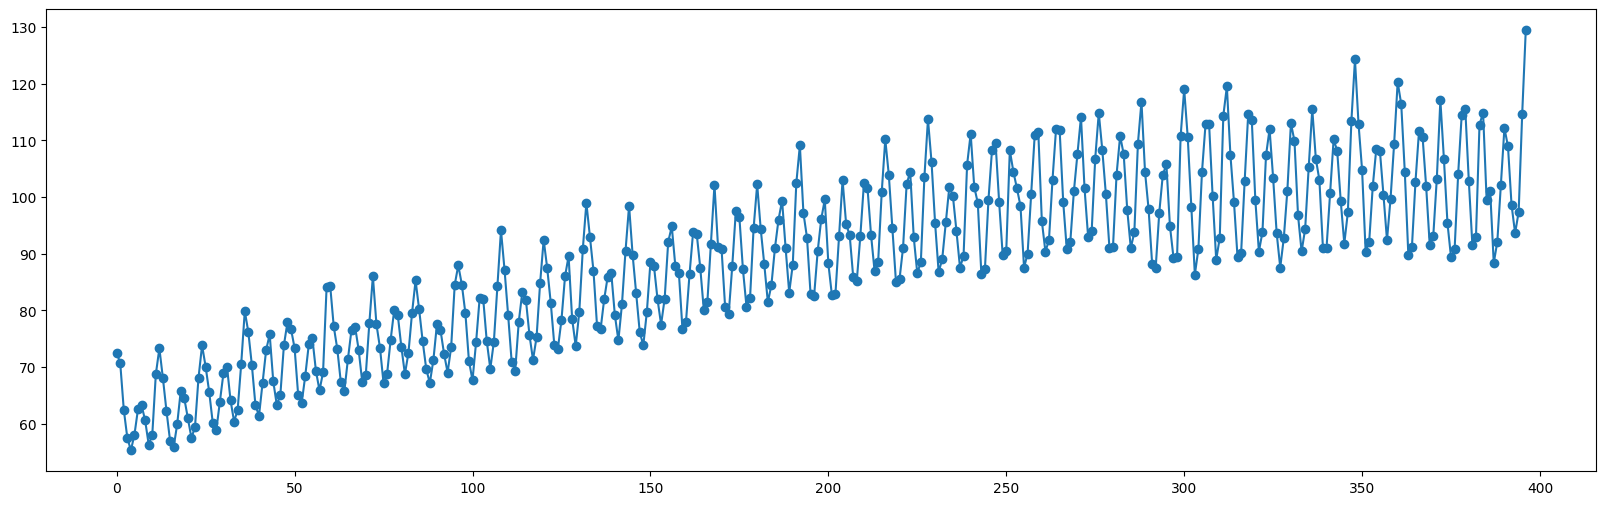

In [199]:
pd.Series(df['values'].values).plot(style='-o')

## Lets apply a Moving average

This is a centered moving average

<Axes: xlabel='DATE'>

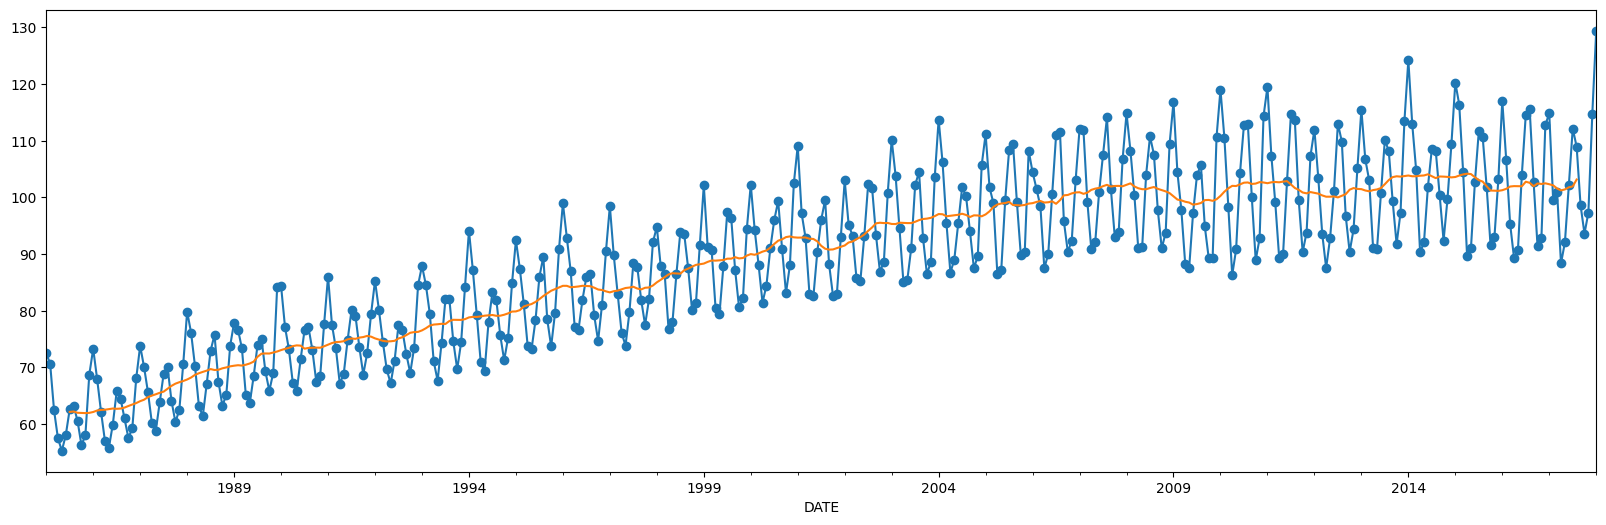

In [202]:
pd.Series(df['values']).plot(style='-o')
pd.Series(df['values']).rolling(12, center=True).mean().plot()

## Decomposition

In [203]:
import statsmodels.api as sm

model = sm.tsa.seasonal_decompose(df['values'], model='additive')

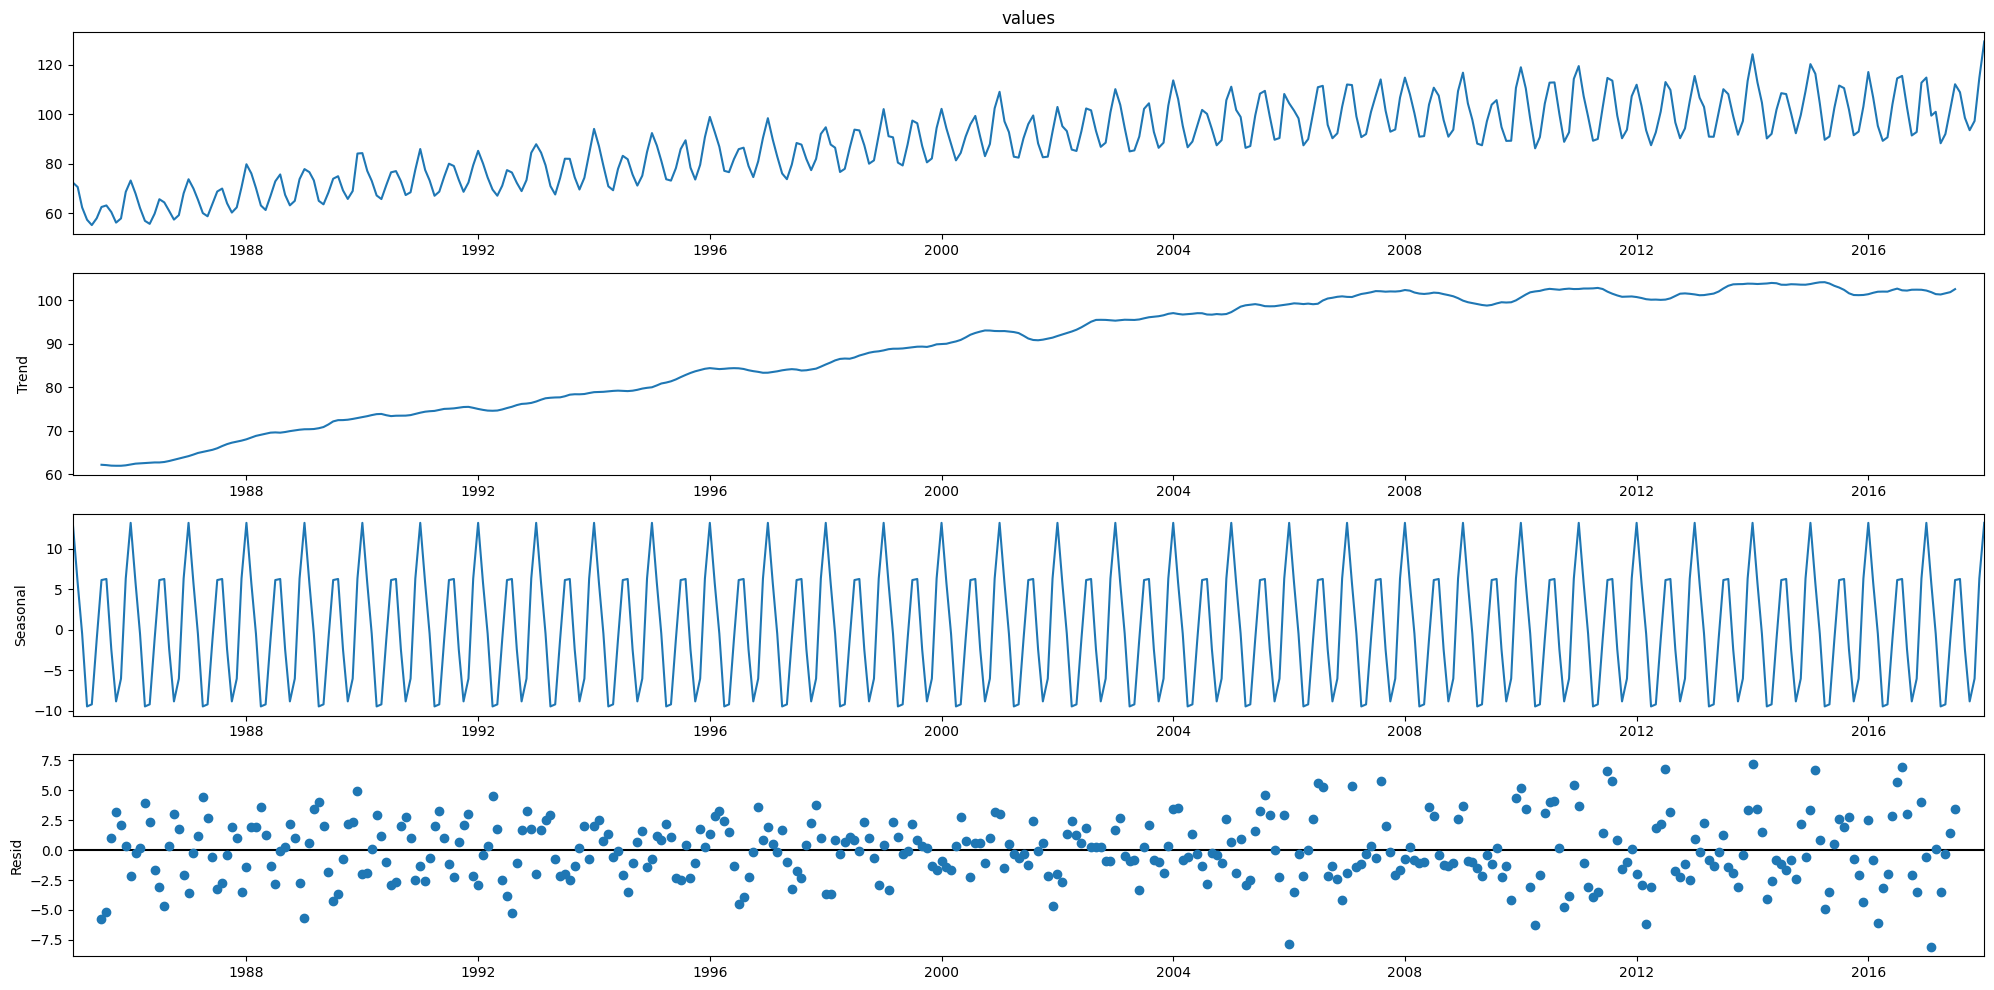

In [205]:
plt.rcParams['figure.figsize'] = (20, 10)
model.plot();

<Axes: xlabel='DATE'>

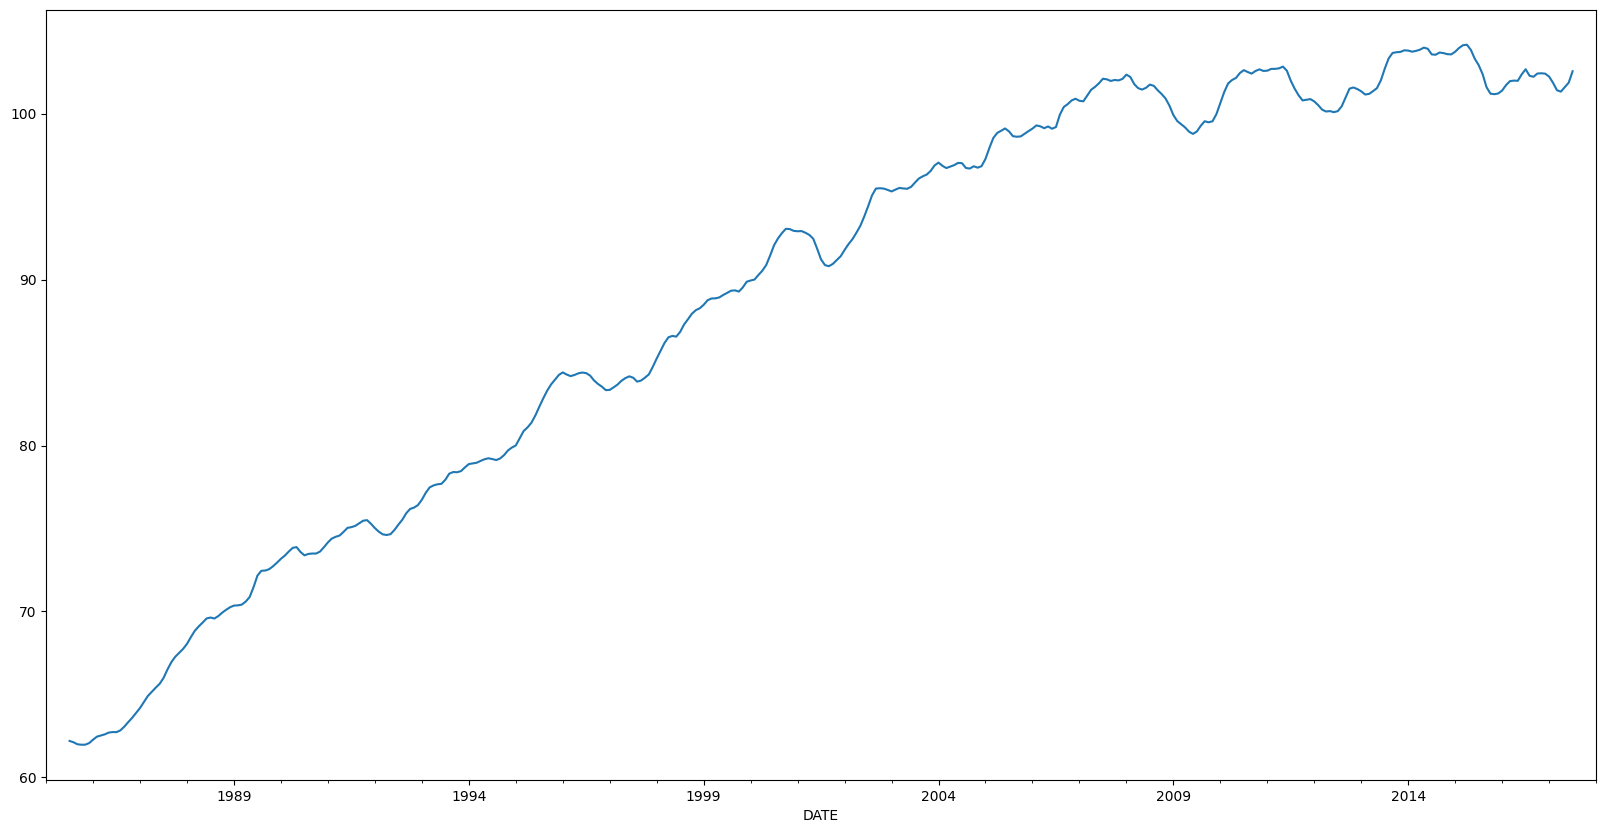

In [206]:
model.trend.plot()

## Simple forcasting techniques

In [207]:
from sklearn.metrics import (
    mean_absolute_error as mae,
    mean_squared_error as mse,
    mean_absolute_percentage_error as mape
)


def performance(actual, predicted):
    print('MAE :', round(mae(actual, predicted), 3))
    print('RMSE :', round(mse(actual, predicted)**0.5, 3)) 
    print('MAPE:', round(mape(actual, predicted), 3))

In [208]:
train_x = df.loc[df.index < df.index[-12]].copy()
test_x = df.loc[df.index >= df.index[-12]].copy()

test_x

,values
DATE,
2017-02-01,99.4901
2017-03-01,101.0396
2017-04-01,88.3530
2017-05-01,92.0805
2017-06-01,102.1532
2017-07-01,112.1538
2017-08-01,108.9312
2017-09-01,98.6154
2017-10-01,93.6137


In [233]:
# Create a pandas Series from the data
series = pd.Series(df.values.flatten())

model = sm.tsa.SimpleExpSmoothing(series).fit(smoothing_level=0.8)
pred = model.forecast(12)


model_2 = sm.tsa.holtwinters.ExponentialSmoothing(series).fit(smoothing_level=0.8)
pred_2 = model_2.forcast(12)

AttributeError: module 'statsmodels.tsa.api' has no attribute 'holtwinters'

NameError: name 'pred_2' is not defined

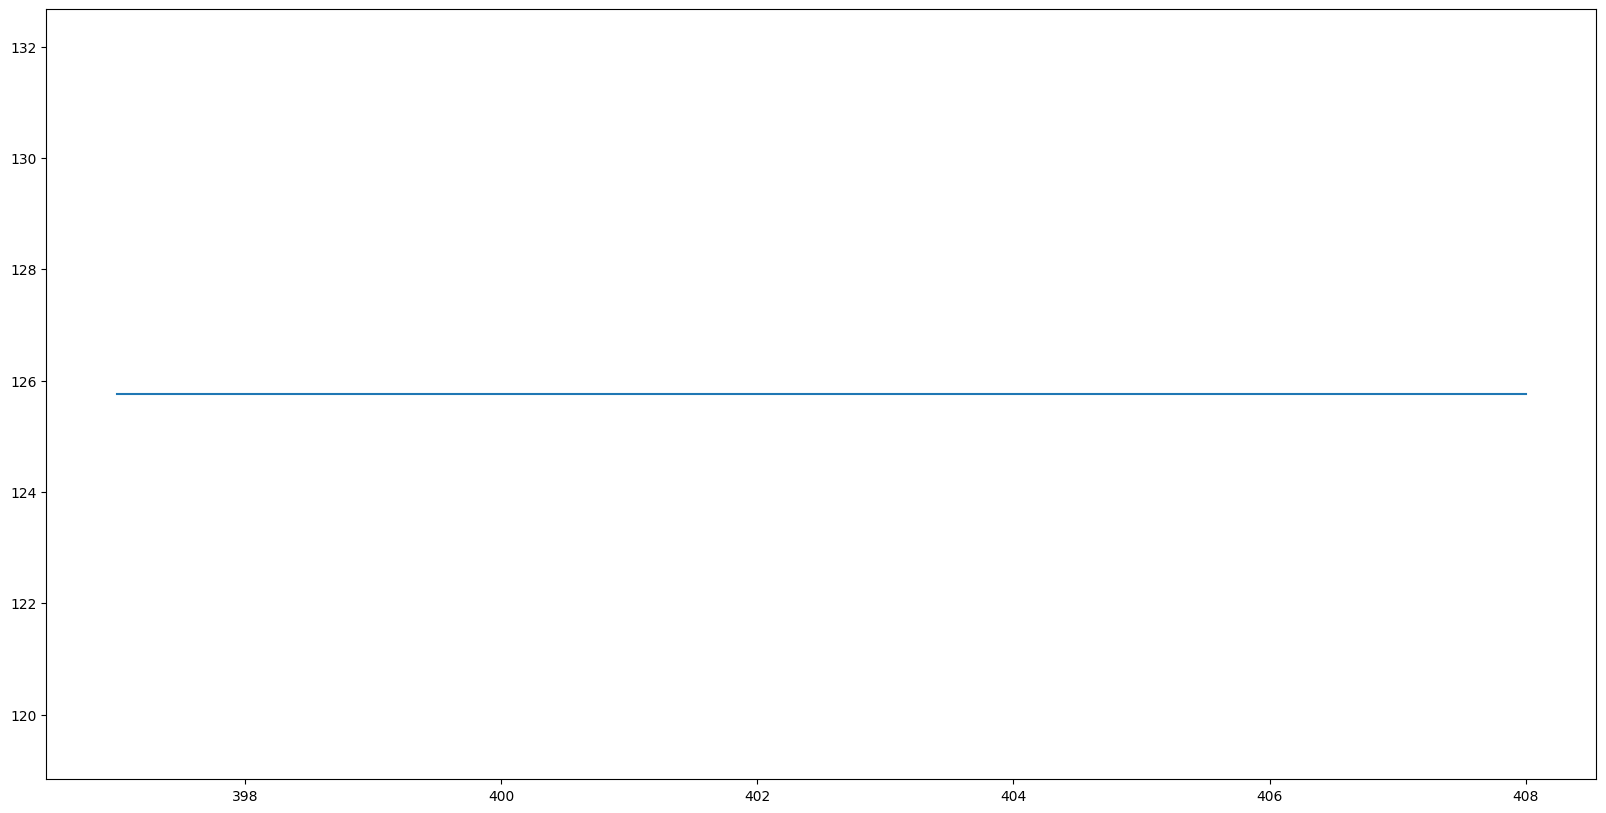

In [234]:
# pred = pd.Series(sm.tsa.SimpleExpSmoothing(df.values).fit(smoothing_level=1/(2*12)).fittedvalues)

pred.plot(label='ses')
pred_2.plot(label='TES')
series.plot(label='original')
series.rolling(12).mean().plot(label='ma12')
plt.legend()

In [214]:
df.index.year.min()

1985

In [215]:
df.index.year.max()

2018

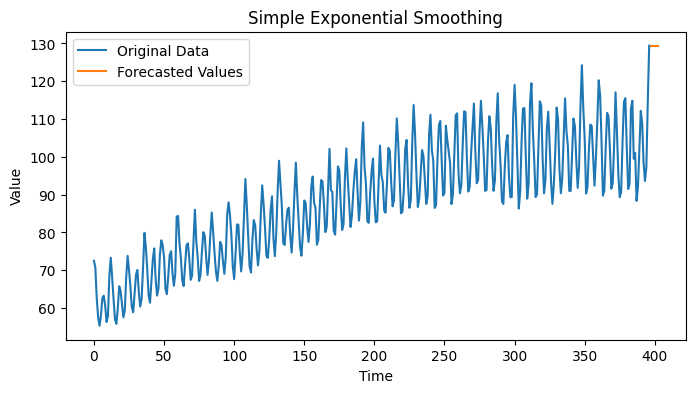

In [229]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Generate some sample data
data = df.values.flatten()

# Create a pandas Series from the data
series = pd.Series(data)

# Perform simple exponential smoothing
model = sm.tsa.SimpleExpSmoothing(series)
fit = model.fit()

# Forecast future values
forecast = fit.predict(start=len(series), end=len(series) + 5)

# Plot the original data and the forecasted values
plt.figure(figsize=(8, 4))
plt.plot(series, label='Original Data')
plt.plot(forecast, label='Forecasted Values')
plt.legend()
plt.title('Simple Exponential Smoothing')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()
